# Batch Processing!
#### A notebook to show some of the capilities available through the pCunch package

This is certainly not an exhaustive look at everything that the pCrunch module can do, but should hopefully provide some insight. 
...or, maybe I'm just procrastinating doing more useful work.

In [1]:
# Python Modules and instantiation
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import os
# %matplotlib widget
# ROSCO toolbox modules 
from ROSCO_toolbox import utilities as rosco_utilities
# WISDEM modules
from wisdem.aeroelasticse.Util import FileTools
# Batch Analysis tools
from pCrunch import Processing, Analysis
from pCrunch import pdTools

# Instantiate fast_IO
fast_io = rosco_utilities.FAST_IO()
fast_pl = rosco_utilities.FAST_Plots()

import importlib
Processing = importlib.reload(Processing)
Analysis = importlib.reload(Analysis)

## Define file paths and filenames
I'm loading a case matrix that is output when using wisdem.aeroelasticse.CaseGen_General to run a series of batch runs to initialize the output files here. 

Note that this isn't necessary, just my workflow in this notebook.

In [ ]:
# point to some file paths
outfile_base = '/Users/nabbas/Documents/Projects/ROSCO_dev/DLC_Analysis/DLC_Outputs/5MW_Land_DLC11/'
fname_case_matrix = os.path.join(outfile_base,'case_matrix.yaml')

In [ ]:
# Load case matrix into datafraome
case_matrix = FileTools.load_yaml(fname_case_matrix, package=1)
cm = pd.DataFrame(case_matrix)

# pull wind speed values from InflowWind filenames
windspeeds, seed, IECtype, cmw = Processing.get_windspeeds(cm, return_df=True)
cmw.head()

#### Comparison cases
I'm comparing two different controllers here, so I'm going to define two lists of output filenames, each corresponding to the output files from each controller

In [4]:
# Define controllers we care to separate things by
controllers = list(set(cmw[('ServoDyn', 'DLL_FileName')]))
controllers

# Parse find outfiles names
outfiles = []
for cont in controllers:
    case_names = cmw[cmw[('ServoDyn','DLL_FileName')]==cont]['Case_Name']
    outnames = list( outfile_base + case_names + '.outb' )
    outfiles.append(outnames)

### outfiles
In the end, we just need a list of OpenFAST output files. Here, we have a structure that looks something like `[[], []]`. This could be extended any amount like `[[],[],...,[], []]`, or just be one list of strings `[]`.

## Now we can do some processing!

First, let's load the FAST_Processing class and initialize some parameters.


In [5]:
fp = Processing.FAST_Processing()
fp.OpenFAST_outfile_list = outfiles
fp.dataset_names = ['DLC1.1', 'DLC1.3']
fp.to = 30
fp.parallel_analysis = True
fp.save_LoadRanking = False
fp.save_SummaryStats = False
fp.verbose=True

# # Can defined specific variables for load ranking if desired
# fp.ranking_vars = [["RotSpeed"], 
#                     ["OoPDefl1", "OoPDefl2", "OoPDefl3"], 
#                     ['RootMxc1', 'RootMxc2', 'RootMxc3'],
#                     ['TwrBsFyt'],
#                     ] 

#### The fast way to compare things.
We could now collect all of the summary stats and load rankings using:
```
stats,load_rankings = fp.batch_processing()
```
In `fp.batch_processing()` most of the analysis is done for any structure of data. I'm going to step through things a bit more piecewise in this notebook, however.

NOTE: The goal in `batch_processing` is to have a "do anything" script. It is a work in progress, but getting there...

In [6]:
# stats,load_rankings = fp.batch_processing()

## Design Comparisons
We can use fp.design_comparison to compare multiple sets of runs (like we are in this case...). This will generate summary stats and load rankings, running in parrallel when it can and is told to. `fp.batch_processing()` functionally does the same thing if we give it an outfile matrix with equal size lists. We'll show the design comparison here to show a break down

In [ ]:
stats, load_ranking = fp.design_comparison(outfiles)

#### Breaking it down further...

`fp.batch_processing()` calls `Analysis.Loads_Analysls.full_loads_analysis()` to load openfast data, generate stats, and calculate load rankings. Because we defined `fp.parallel_analysis=True` this process was parallelized. This helps for speed and memory reasons, because now every openfast run is not saved. `fp.batch_processing()` then takes all of the output data and parses it back together. 

Separately, we call call `Analysis.Loads_Analysls.full_loads_analysis()` with `return_FastData=True` and all of the fast data will be returned. Because we are comparing data though, we'll stick with the design comparison tools.


#### Loading data
We can also just load previously parsed data if we ran `FAST_Processing` with the `save_LoadRankings` and `save_SummaryStates` flags as True.

In [7]:
# Or load stats and load rankings
root = '/Users/nabbas/Documents/Projects/ROSCO_dev/DLC_Analysis/DLC_Outputs/5MW_Land_DLC11/stats/'
lrfile = [root+'dataset0_LoadRanking.yaml', root+'dataset1_LoadRanking.yaml']
sfile = [root+'dataset0_stats.yaml', root+'dataset1_stats.yaml']
fname_case_matrix = root+'../case_matrix.yaml'

stats = [FileTools.load_yaml(sf, package=1) for sf in sfile]
load_rankings = [FileTools.load_yaml(lf, package=1) for lf in lrfile]
case_matrix = FileTools.load_yaml(fname_case_matrix, package=1)
cm = pd.DataFrame(case_matrix)

### We can look at our data a bit further with pandas dataframes
The data here is just for a few runs for simplicity. Usually you'd do this for a LOT more cases...

In [405]:
stats_df = pdTools.dict2df(stats, names=['ROSCO', 'Legacy'])
stats_df.head()

ROSCO                                                               \
      Azimuth                                                                
          abs     integrated         max        mean       min         std   
0  359.998240  -28079.032179  359.998240  180.070780  0.005493  103.922486   
1  359.995494  112369.180639  359.995494  180.221511  0.000000  104.036039   
2  359.995977   78379.225867  359.995977  180.422515  0.005493  103.744314   
3  359.998813  101118.227566  359.998813  179.866370  0.005493  103.715619   
4  359.999869  -92631.217997  359.999869  180.376818  0.005493  103.948726   

                                  ...       Legacy                           \
  B1N3Clrnc                       ...     YawBrMyp                            
        abs integrated  max mean  ...          max        mean          min   
0       0.0        0.0  0.0  0.0  ...  1835.180850 -617.729937 -2961.282261   
1       0.0        0.0  0.0  0.0  ...  1680.603818 -623.212298 -2644.343078   
2       0.0        0.0  0.0  0.0  ...  1703.535253 -626.186456 -2840.674342   
3       0.0        0.0  0.0  0.0  ...  2495.420439 -620.042793 -2952.444972   
4       0.0        0.0  0.0  0.0  ...  1855.491644 -619.192258 -3027.630559   

                                                                               \
                  YawBrMzp                                                      
          std          abs    integrated          max       mean          min   
0  725.222118  2635.558528 -1.652391e+06  2050.139529  22.654148 -2635.558528   
1  720.083306  3321.220837  5.746526e+05  3321.220837  70.472030 -2305.507007   
2  659.873180  2756.976649 -4.381119e+05  2668.645868  58.023861 -2756.976649   
3  810.684759  2517.608832 -2.774194e+04  2517.608832  37.165318 -2444.651861   
4  784.534704  2350.658038 -6.571397e+05  2155.542861  32.344596 -2350.658038   

               
               
          std  
0  781.043501  
1  779.963400  
2  758.107664  
3  762.062726  
4  708.792892  

[5 rows x 1296 columns]

### Load Ranking
Lets re-run the load ranking for the sake of example. We'll have to load the analysis tools, and then run the load ranking for the stats we just found

In [406]:
fa = Analysis.Loads_Analysis()
fa.t0 = 30
fa.verbose = False

Define the ranking variables and statiscits of interest. Note that `len(ranking_vars) == len(ranking_stats)`! We can pass this a list of stats (multiple runs), a dictionary with one run of stats, or a pandas dataframe with the requisite stats. If the inner list contains multiple OpenFAST channels, the load_rankings function will find the min/max/mean of the collection of the channels (e.g., max out of plane tip deflection of all three blades).  

We'll also output a dictionary and a pandas DataFrame from `fa.load_ranking()`

In [407]:
fa.ranking_vars = [['TwrBsFxt'], ['OoPDefl1', 'OoPDefl2', 'OoPDefl3']]
fa.ranking_stats = ['max', 'min']
load_ranking, load_ranking_df = fa.load_ranking(stats_df, get_df=True)
load_ranking_df.head()

Legacy                                            ROSCO               \
    OoPDefl                  TwrBsFxt                OoPDefl                
        min min_case_idx          max max_case_idx       min min_case_idx   
0 -5.728831          124  1056.707299           71 -6.188782          124   
1 -5.450257          118  1051.551571           59 -5.834956          118   
2 -5.170558          112  1045.319987           72 -5.424737          112   
3 -4.890074          106  1044.365045           64 -4.935649          106   
4 -4.621811          125  1044.056716           70 -4.867224          125   

                             
      TwrBsFxt               
           max max_case_idx  
0  1537.914432          105  
1  1510.615793           99  
2  1492.296877           93  
3  1461.854360           87  
4  1409.860287          112

This is organized for each iteration of `[ranking_vars, ranking_stats]`. The stats are ordered accordingly, and `(stat)_case_idx` refers to the case name index of each load. 

## Wind speed related analysis
We often want to make sense of some batch output data with data binned by windspeed. We can leverage the case-matrix from our output data to figure out the input wind speeds. Of course, `('InflowWind', 'Filename')` must exist in the case matrix. Lets load the wind speeds, save them, and append them to the case matrix as `('InflowWind', 'WindSpeed')`.

In [408]:
windspeed, seed, IECtype, cmw = Processing.get_windspeeds(cm, return_df=True)
cmw

,"(IEC, DLC)","(AeroDyn15, TwrAero)","(DISCON_in, Fl_Mode)","(DISCON_in, PS_Mode)","(DISCON_in, PerfFileName)","(ElastoDyn, BlPitch1)","(ElastoDyn, BlPitch2)","(ElastoDyn, BlPitch3)","(ElastoDyn, RotSpeed)","(Fst, OutFileFmt)","(Fst, TMax)","(InflowWind, Filename)","(InflowWind, WindType)","(ServoDyn, DLL_FileName)",Case_ID,Case_Name,"(InflowWind, WindSpeed)","(InflowWind, Seed)","(InflowWind, IECtype)"
0,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,0.000,0.000,0.000,7.506,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,0,5MW_Land_2_000,5.0,54321.0,NTM
1,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,0.000,0.000,0.000,7.506,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,1,5MW_Land_2_001,5.0,54321.0,NTM
2,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,0.000,0.000,0.000,7.506,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,2,5MW_Land_2_002,5.0,12345.0,NTM
3,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,0.000,0.000,0.000,7.506,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,3,5MW_Land_2_003,5.0,12345.0,NTM
4,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,0.000,0.000,0.000,7.506,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,4,5MW_Land_2_004,5.0,165134.0,NTM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,23.469,23.469,23.469,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,247,5MW_Land_2_247,25.0,12352.0,NTM
248,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,23.469,23.469,23.469,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,248,5MW_Land_2_248,25.0,56612.0,NTM
249,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,23.469,23.469,23.469,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,249,5MW_Land_2_249,25.0,56612.0,NTM
250,1.1,True,0,0,/projects/ssc/nabbas/TurbineModels/5MW_Baselin...,23.469,23.469,23.469,12.100,2,660,/lustre/eaglefs/projects/ssc/nabbas/DLC_Analys...,3,/home/nabbas/ROSCO_toolbox/ROSCO/build/libdisc...,250,5MW_Land_2_250,25.0,61235.0,NTM


### AEP
Now that we know the wind speeds that we were operating at, we can find the AEP. We define the turbine class here, and the cumulative distribution or probability density function 
for the Weibull distribution per IEC 61400 is generated. We can then calculate the AEP. 

If we first want to verify the PDF, we initialize the `power_production` function, define the turbine class, and can plot a PDF (or CDF) for a given range of wind speeds:

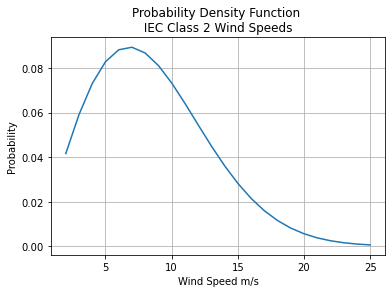

In [409]:
pp = Analysis.Power_Production()
pp.turbine_class = 2
Vrange = np.arange(2,26) # Range of wind speeds being considered
weib_prob = pp.prob_WindDist(Vrange,disttype='pdf')
plt.close('all')
plt.plot(Vrange, weib_prob)
plt.grid(True)
plt.xlabel("Wind Speed m/s")
plt.ylabel('Probability')
plt.title('Probability Density Function \n IEC Class 2 Wind Speeds ')
plt.show()


To get the AEP, we need to provide the wind speeds that the simulations were run for, and the corresponding average power results. Internally, in power_production.AEP, the mean power for a given average wind sped is multiplied times the wind speed's probability, then extrapolated to represent yearly production. 

Note: this might throw a python warning due to some poor pandas indexing practices - to be cleaned up eventually!

To get the AEP for each, the process is simple:

In [411]:
AEP = pp.AEP(stats, windspeeds)
print('AEP = {}'.format(AEP))

AEP = [22792675.10042736 22727677.57731066]


##### About the wind speed warning:
Here, we get a warning about the input windspeed array. This is because we passed the complete array output from Processing.get_windspeeds to the AEP function. The input windspeeds to power_production.AEP must satisfy either of the following two conditions:
- each wind speed value corresponds to each each statistic value, so `len(windspeeds) = len(stats_df)`
- each wind speed value corresponds to each run in the case matrix, so `len(windspeeds) = len(cm)`

If the second of these conditions is satisfied, it is assumed that each dataset has the same wind speeds corresponding to each run. So, in this case, the wind speeds corresponding to DLC_1.1 and DLC_1.3 should be the same. 

## Plotting
Finally, we can make some plots. There are a few tools we have at our disposal here. First, we can look at more plots that show our design performance as a function of wind speed. Notably, we can pass the stats dictionary or dataframe to these statistics-related scripts.

Currently, `an_plts.stat_curve()` can plot a "statistics curve" for of two types, a bar or a line graph. 

A bar graph is useful to compare design cases easily:

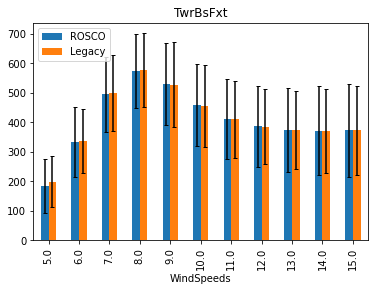

In [412]:
plt.close()
an_plts = Analysis.wsPlotting()
an_plts.stat_curve(windspeed, stats, 'TwrBsFxt', 'bar', names=['ROSCO', 'Legacy'])
plt.show()

A line graph can be useful to show turbulent wind curves. Here we show the means with a first level of errorbars corresponding to standard deviations, and a second level showing minimums and maximums.

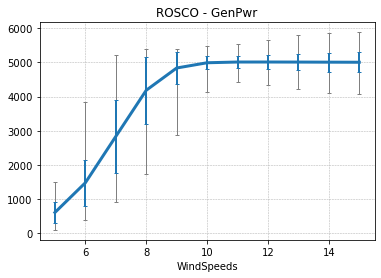

In [413]:
an_plts.stat_curve(windspeed, stats, 'GenPwr', 'line', stat_idx=0, names=['ROSCO'])
plt.show()

### Load Ranking (soon)
We can plot the load rankings... 
... pulling this into `Analysis.py` is in progress.

First, we define how we will classify our comparisons. Most commonly this would be `('IEC','DLC')`, but I'm comparing controllers here. The `classifier_type` functionally refers to the channel of the case matrix to separate the data by, and the `classifier_names` are simply labels for the classifiers. 

In [414]:
# Define a classification channel from the case-matrix 
classifier_type = ('ServoDyn', 'DLL_FileName')
classifier_names = ['ROSCO', 'legacy']

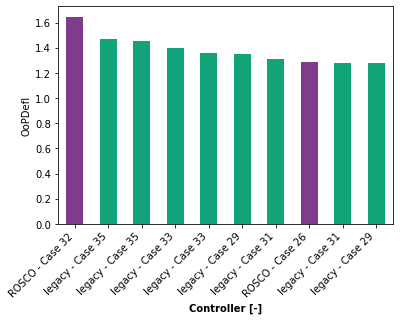

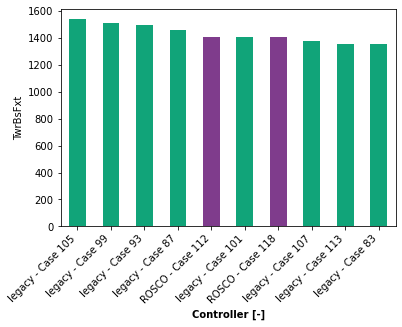

In [415]:
# Plot load rankings
fig_list, ax_list = an_plts.plot_load_ranking(load_ranking, cm, classifier_type, classifier_names=classifier_names, n_rankings=10, caseidx_labels=True)

# modify axis labels
for ax in ax_list:
    ax.set_xlabel('Controller [-]', fontsize=10, fontweight='bold')
plt.show()

### Time domain plotting
We can also look at our data from the time domain results. 

We can compare any number of channels using the ROSCO toolbox plotting tools. First we'll load two cases to plot together, then plot the time histories.

In [423]:
#  Load some time domain cases 
filenames = [outfiles[0][70], outfiles[1][70]] # select the 70th run from each dataset
fast_data = fast_io.load_FAST_out(filenames, tmin=30)

# Change names so the legends make sense
fast_data[0]['meta']['name'] = 'ROSCO'
fast_data[1]['meta']['name'] = 'Legacy'

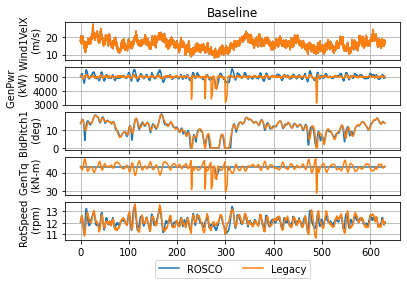

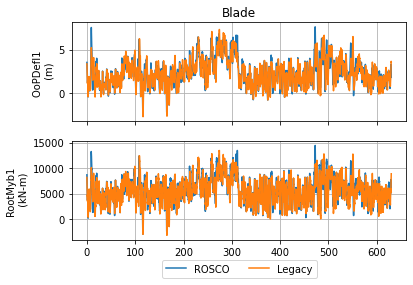

In [424]:
# Define the plots we want to make (can be as many or as few channels and plots as you would like...)
cases = {'Baseline': ['Wind1VelX', 'GenPwr', 'BldPitch1', 'GenTq', 'RotSpeed'],
        'Blade' : ['OoPDefl1', 'RootMyb1']}

# plot
fast_pl.plot_fast_out(cases, fast_data)
plt.show()

### Spectral Analysis

We can additionally do some frequency domain analysis. Here, `spec_cases` is defined by `(channel, run)` where the run index corresponds to the desired plotting index in the loaded fast data.



[WARN] dt from tmax-tmin different from dt from t2-t1
[WARN] dt from tmax-tmin different from dt from t2-t1


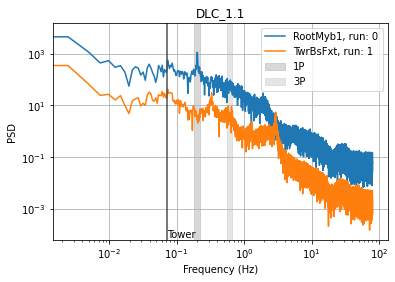

In [19]:
spec_cases = [('RootMyb1', 0), ('TwrBsFxt', 1)]
twrfreq = .0716
twrfreq_label = ['Tower']
fig, ax = fast_pl.plot_spectral(fast_data, spec_cases, 
                                show_RtSpeed=True, RtSpeed_idx=[0],
                                add_freqs=[twrfreq], add_freq_labels=twrfreq_label,
                                averaging='Welch')
ax.set_title('DLC_1.1')
plt.show()

### Other fun plots

Finally, we can plot the data distribution of any channels from our fast output data

In [127]:
channels = ['GenPwr']
caseid = [0,1]
an_plts.distribution(fast_data, channels, caseid, names=['ROSCO', 'Legacy'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## In conclusion...
If you made it this far, thanks for reading... 

There are a number of smaller subfunctionalities that are also available within these tools shows above. Perhaps most importantly, everything is fairly modularar - the hope being that these can provide some high-level tools that everyone can assimilate into their own workflows without too much disruption.

Please add, contribute, fix, etc... That would be great for everyone involved!